In [1]:
# Check if CUDA

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("❌ CUDA not detected by PyTorch")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU count: 1
GPU name: NVIDIA GeForce RTX 2060
GPU memory: 6.0 GB


In [10]:
!pip install torch torchvision pillow matplotlib --quiet

#### Original training

Using device: cuda
Preparing training data...
Processed 0/361 images
Processed 50/361 images
Processed 100/361 images
Processed 150/361 images
Processed 200/361 images
Processed 250/361 images
Processed 300/361 images
Processed 350/361 images
Training data ready: 361 pairs created
Preparing test data...
Test data ready: 108 images copied
Setting up training...
Starting training for 50 epochs...
Epoch [0/50], Batch [0/91], Loss: 0.7174
Epoch [0/50], Batch [20/91], Loss: 0.1672
Epoch [0/50], Batch [40/91], Loss: 0.1665
Epoch [0/50], Batch [60/91], Loss: 0.1267
Epoch [0/50], Batch [80/91], Loss: 0.1672
Epoch [0/50] completed. Average Loss: 0.2006
Epoch [1/50], Batch [0/91], Loss: 0.1572
Epoch [1/50], Batch [20/91], Loss: 0.1300
Epoch [1/50], Batch [40/91], Loss: 0.1354
Epoch [1/50], Batch [60/91], Loss: 0.1168
Epoch [1/50], Batch [80/91], Loss: 0.1024
Epoch [1/50] completed. Average Loss: 0.1262
Epoch [2/50], Batch [0/91], Loss: 0.1047
Epoch [2/50], Batch [20/91], Loss: 0.1052
Epoch [2/50

G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Colorized: test_0048.png
Colorized: test_0049.png
Colorized: test_0050.png
Colorized: test_0051.png
Colorized: test_0052.png
Colorized: test_0053.png
Colorized: test_0054.png
Colorized: test_0055.png
Colorized: test_0056.png
Colorized: test_0057.png
Colorized: test_0058.png
Colorized: test_0059.png
Colorized: test_0060.png
Colorized: test_0061.png
Colorized: test_0062.png
Colorized: test_0063.png
Colorized: test_0064.png
Colorized: test_0065.png
Colorized: test_0066.png
Colorized: test_0067.png
Colorized: test_0068.png
Colorized: test_0069.png
Colorized: test_0070.png
Colorized: test_0071.png
Colorized: test_0072.png
Colorized: test_0073.png
Colorized: test_0074.png
Colorized: test_0075.png
Colorized: test_0076.png
Colorized: test_0077.png
Colorized: test_0078.png
Colorized: test_0079.png
Colorized: test_0080.png
Colorized: test_0081.png
Colorized: test_0082.png
Colorized: test_0083.png
Colorized: test_0084.png
Colorized: test_0085.png
Colorized: test_0086.png
Colorized: test_0087.png


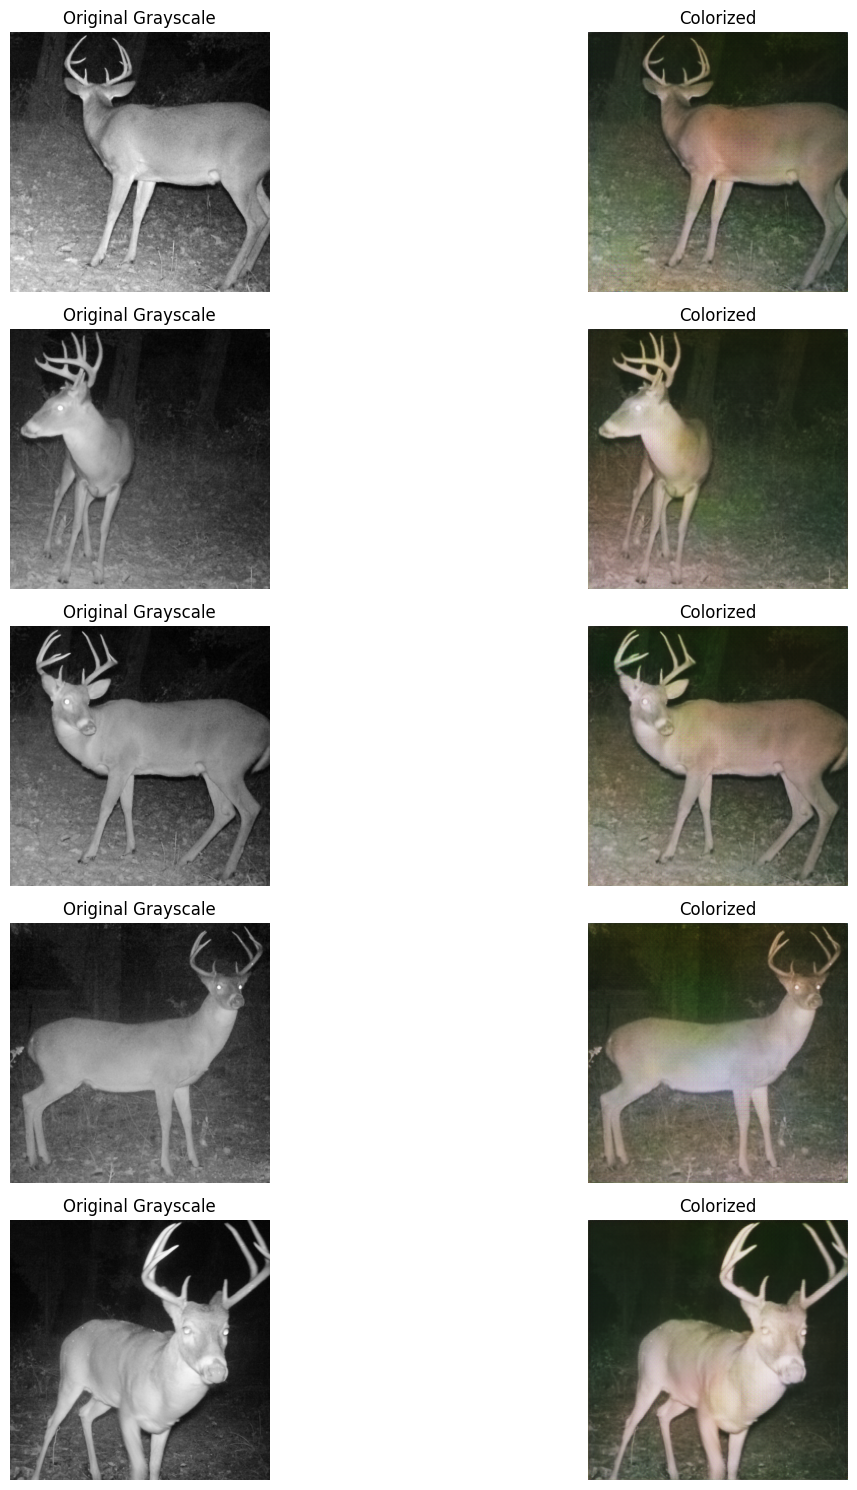

Preparing training data...
Processed 0/361 images
Processed 50/361 images
Processed 100/361 images
Processed 150/361 images
Processed 200/361 images
Processed 250/361 images
Processed 300/361 images
Processed 350/361 images
Training data ready: 361 pairs created
Preparing test data...
Test data ready: 108 images copied


In [11]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set paths
color_path = Path("G:/Dropbox/AI Projects/buck/images/squared/color/")
gray_path = Path("G:/Dropbox/AI Projects/buck/images/squared/grayscale/")
data_path = Path("./deer_training_data/")
model_path = Path("./models/")

# Create directories
data_path.mkdir(parents=True, exist_ok=True)
model_path.mkdir(parents=True, exist_ok=True)
(data_path / "train_gray").mkdir(parents=True, exist_ok=True)
(data_path / "train_color").mkdir(parents=True, exist_ok=True)
(data_path / "test_gray").mkdir(parents=True, exist_ok=True)

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.conv = nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2) if down else nn.ReLU()
        self.dropout = nn.Dropout(0.5) if use_dropout else None
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        if self.dropout:
            x = self.dropout(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder (downsampling)
        self.down1 = nn.Conv2d(1, 64, 4, 2, 1)  # Input: grayscale (1 channel)
        self.down2 = UNetBlock(64, 128, down=True)
        self.down3 = UNetBlock(128, 256, down=True)
        self.down4 = UNetBlock(256, 512, down=True)
        self.down5 = UNetBlock(512, 512, down=True)
        self.down6 = UNetBlock(512, 512, down=True)
        
        # Bottleneck
        self.bottleneck = UNetBlock(512, 512, down=True, use_dropout=True)
        
        # Decoder (upsampling)
        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False)
        self.up4 = UNetBlock(1024, 256, down=False)
        self.up5 = UNetBlock(512, 128, down=False)
        self.up6 = UNetBlock(256, 64, down=False)
        
        # Final layer
        self.final = nn.ConvTranspose2d(128, 3, 4, 2, 1)  # Output: RGB (3 channels)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        
        # Bottleneck
        bottleneck = self.bottleneck(d6)
        
        # Decoder with skip connections
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d6], 1))
        up3 = self.up3(torch.cat([up2, d5], 1))
        up4 = self.up4(torch.cat([up3, d4], 1))
        up5 = self.up5(torch.cat([up4, d3], 1))
        up6 = self.up6(torch.cat([up5, d2], 1))
        
        final = self.final(torch.cat([up6, d1], 1))
        return self.tanh(final)

class DeerDataset(Dataset):
    def __init__(self, gray_dir, color_dir, transform=None):
        self.gray_dir = Path(gray_dir)
        self.color_dir = Path(color_dir)
        self.transform = transform
        self.gray_files = list(self.gray_dir.glob("*.png"))
        
    def __len__(self):
        return len(self.gray_files)
    
    def __getitem__(self, idx):
        gray_path = self.gray_files[idx]
        color_path = self.color_dir / gray_path.name
        
        gray_img = Image.open(gray_path).convert('L')
        color_img = Image.open(color_path).convert('RGB')
        
        if self.transform:
            gray_img = self.transform(gray_img)
            color_img = self.transform(color_img)
        
        return gray_img, color_img

def convert_to_grayscale(image_path, output_path):
    """Convert color image to grayscale"""
    img = Image.open(image_path).convert('RGB')
    gray_img = img.convert('L')
    gray_img.save(output_path)

def prepare_training_data():
    """Create training pairs from color images"""
    print("Preparing training data...")
    
    color_files = list(color_path.glob("*.png"))
    
    for i, color_file in enumerate(color_files):
        # Copy original color image
        shutil.copy(color_file, data_path / "train_color" / f"deer_{i:04d}.png")
        
        # Create corresponding grayscale version
        gray_output = data_path / "train_gray" / f"deer_{i:04d}.png"
        convert_to_grayscale(color_file, gray_output)
        
        if i % 50 == 0:
            print(f"Processed {i}/{len(color_files)} images")
    
    print(f"Training data ready: {len(color_files)} pairs created")

def prepare_test_data():
    """Copy actual grayscale images for testing"""
    print("Preparing test data...")
    
    gray_files = list(gray_path.glob("*.png"))
    
    for i, gray_file in enumerate(gray_files):
        shutil.copy(gray_file, data_path / "test_gray" / f"test_{i:04d}.png")
    
    print(f"Test data ready: {len(gray_files)} images copied")

def train_model(epochs=50, batch_size=4, lr=0.0002):
    """Train the colorization model"""
    print("Setting up training...")
    
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    # Dataset and dataloader
    dataset = DeerDataset(data_path / "train_gray", data_path / "train_color", transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    # Model
    generator = Generator().to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        epoch_loss = 0
        for i, (gray, color) in enumerate(dataloader):
            gray = gray.to(device)
            color = color.to(device)
            
            optimizer.zero_grad()
            
            # Generate colorized image
            fake_color = generator(gray)
            
            # Calculate loss
            loss = criterion(fake_color, color)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if i % 20 == 0:
                print(f"Epoch [{epoch}/{epochs}], Batch [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")
        
        print(f"Epoch [{epoch}/{epochs}] completed. Average Loss: {epoch_loss/len(dataloader):.4f}")
        
        # Save model checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(generator.state_dict(), model_path / f"deer_colorizer_epoch_{epoch+1}.pth")
    
    # Save final model
    torch.save(generator.state_dict(), model_path / "deer_colorizer_final.pth")
    print("Training completed and model saved!")
    
    return generator

def load_model():
    """Load the trained model"""
    generator = Generator().to(device)
    generator.load_state_dict(torch.load(model_path / "deer_colorizer_final.pth", map_location=device))
    generator.eval()
    return generator

def colorize_test_images(model):
    """Colorize the test grayscale images"""
    print("Colorizing test images...")
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    test_files = list((data_path / "test_gray").glob("*.png"))
    output_path = Path("./colorized_results/")
    output_path.mkdir(parents=True, exist_ok=True)
    
    with torch.no_grad():
        for test_file in test_files:
            # Load and preprocess image
            gray_img = Image.open(test_file).convert('L')
            gray_tensor = transform(gray_img).unsqueeze(0).to(device)
            
            # Generate colorized image
            colorized_tensor = model(gray_tensor)
            
            # Convert back to PIL image
            colorized_tensor = (colorized_tensor + 1) / 2  # Denormalize
            colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze().cpu())
            
            # Save result
            output_file = output_path / f"colorized_{test_file.name}"
            colorized_img.save(output_file)
            
            print(f"Colorized: {test_file.name}")
    
    print(f"Results saved to {output_path}")

def show_sample_results(model, num_samples=5):
    """Display sample colorization results"""
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    test_files = list((data_path / "test_gray").glob("*.png"))[:num_samples]
    
    plt.figure(figsize=(15, num_samples * 3))
    
    with torch.no_grad():
        for i, test_file in enumerate(test_files):
            # Load and process image
            gray_img = Image.open(test_file).convert('L')
            gray_tensor = transform(gray_img).unsqueeze(0).to(device)
            
            # Generate colorized image
            colorized_tensor = model(gray_tensor)
            colorized_tensor = (colorized_tensor + 1) / 2  # Denormalize
            colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze().cpu())
            
            # Display results
            plt.subplot(num_samples, 2, i*2 + 1)
            plt.imshow(gray_img, cmap='gray')
            plt.title('Original Grayscale')
            plt.axis('off')
            
            plt.subplot(num_samples, 2, i*2 + 2)
            plt.imshow(colorized_img)
            plt.title('Colorized')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Execution pipeline
if __name__ == "__main__":
    # Step 1: Prepare data
    prepare_training_data()
    prepare_test_data()
    # Step 2: Train model
    model = train_model(epochs=50, batch_size=4)
    # Step 3: Test on grayscale images
    colorize_test_images(model)
    # Step 4: Show sample results
    show_sample_results(model)

#### Training -- adding perception loss

Using device: cuda
Preparing training data...
Processed 0/361 images
Processed 50/361 images
Processed 100/361 images
Processed 150/361 images
Processed 200/361 images
Processed 250/361 images
Processed 300/361 images
Processed 350/361 images
Training data ready: 361 pairs created
Preparing test data...
Test data ready: 108 images copied
Setting up training...
Starting training for 50 epochs...
Epoch [0/50], Batch [0/91], Loss: 0.5982
Epoch [0/50], Batch [20/91], Loss: 0.2037
Epoch [0/50], Batch [40/91], Loss: 0.2104
Epoch [0/50], Batch [60/91], Loss: 0.2002
Epoch [0/50], Batch [80/91], Loss: 0.1427
Epoch [0/50] completed. Average Loss: 0.2083
Epoch [1/50], Batch [0/91], Loss: 0.1399
Epoch [1/50], Batch [20/91], Loss: 0.1147
Epoch [1/50], Batch [40/91], Loss: 0.1050
Epoch [1/50], Batch [60/91], Loss: 0.1278
Epoch [1/50], Batch [80/91], Loss: 0.1397
Epoch [1/50] completed. Average Loss: 0.1260
Epoch [2/50], Batch [0/91], Loss: 0.1253
Epoch [2/50], Batch [20/91], Loss: 0.0892
Epoch [2/50

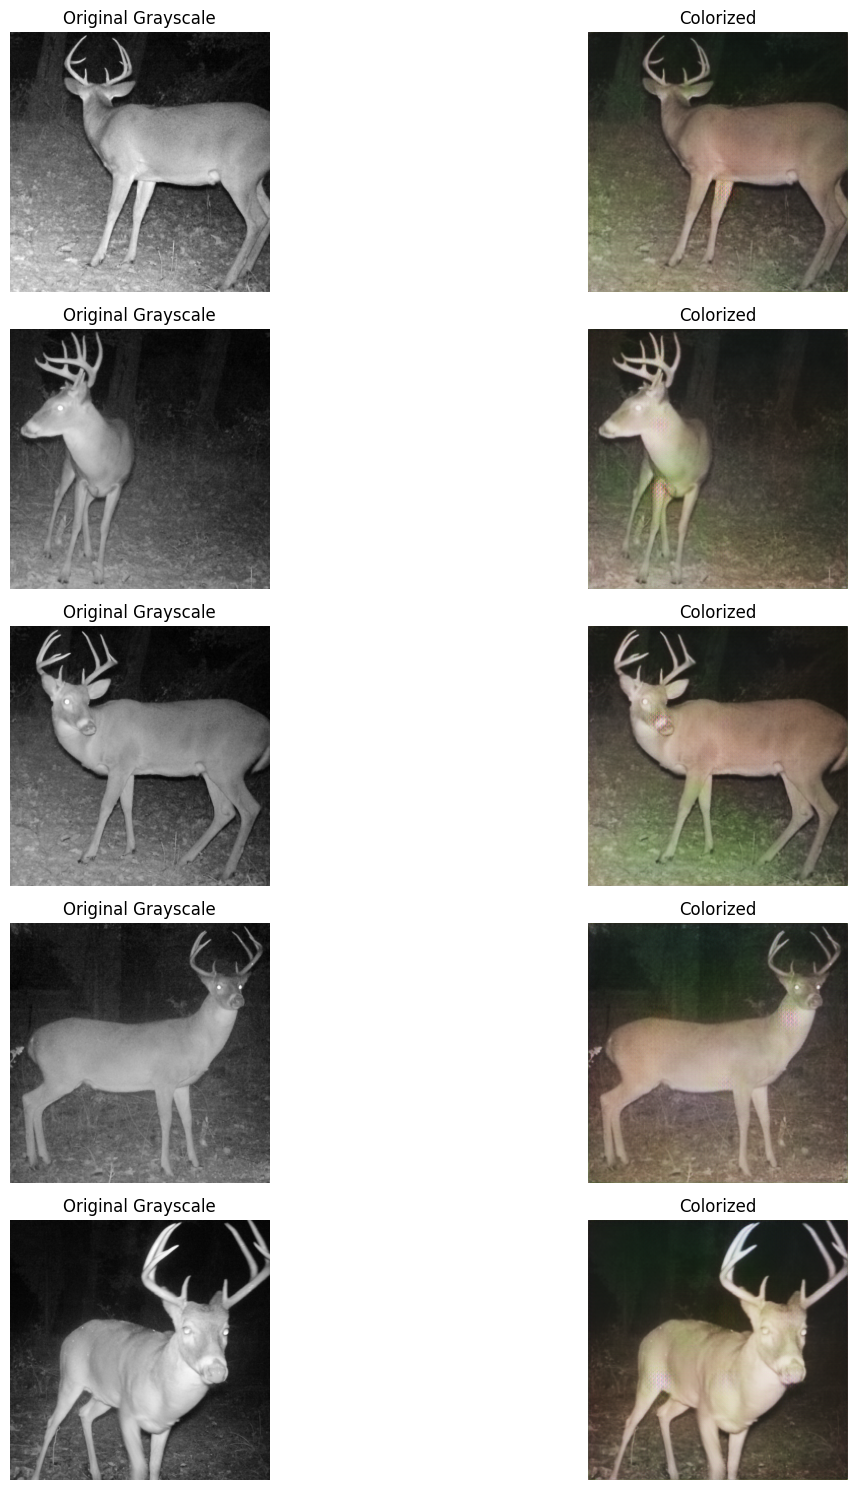

In [12]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set paths
color_path = Path("G:/Dropbox/AI Projects/buck/images/squared/color/")
gray_path = Path("G:/Dropbox/AI Projects/buck/images/squared/grayscale/")
data_path = Path("./deer_training_data/")
model_path = Path("./models/")

# Create directories
data_path.mkdir(parents=True, exist_ok=True)
model_path.mkdir(parents=True, exist_ok=True)
(data_path / "train_gray").mkdir(parents=True, exist_ok=True)
(data_path / "train_color").mkdir(parents=True, exist_ok=True)
(data_path / "test_gray").mkdir(parents=True, exist_ok=True)

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.conv = nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2) if down else nn.ReLU()
        self.dropout = nn.Dropout(0.5) if use_dropout else None
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        if self.dropout:
            x = self.dropout(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder (downsampling)
        self.down1 = nn.Conv2d(1, 64, 4, 2, 1)  # Input: grayscale (1 channel)
        self.down2 = UNetBlock(64, 128, down=True)
        self.down3 = UNetBlock(128, 256, down=True)
        self.down4 = UNetBlock(256, 512, down=True)
        self.down5 = UNetBlock(512, 512, down=True)
        self.down6 = UNetBlock(512, 512, down=True)
        
        # Bottleneck
        self.bottleneck = UNetBlock(512, 512, down=True, use_dropout=True)
        
        # Decoder (upsampling)
        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False)
        self.up4 = UNetBlock(1024, 256, down=False)
        self.up5 = UNetBlock(512, 128, down=False)
        self.up6 = UNetBlock(256, 64, down=False)
        
        # Final layer
        self.final = nn.ConvTranspose2d(128, 3, 4, 2, 1)  # Output: RGB (3 channels)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        
        # Bottleneck
        bottleneck = self.bottleneck(d6)
        
        # Decoder with skip connections
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d6], 1))
        up3 = self.up3(torch.cat([up2, d5], 1))
        up4 = self.up4(torch.cat([up3, d4], 1))
        up5 = self.up5(torch.cat([up4, d3], 1))
        up6 = self.up6(torch.cat([up5, d2], 1))
        
        final = self.final(torch.cat([up6, d1], 1))
        return self.tanh(final)

class DeerDataset(Dataset):
    def __init__(self, gray_dir, color_dir, transform=None):
        self.gray_dir = Path(gray_dir)
        self.color_dir = Path(color_dir)
        self.transform = transform
        self.gray_files = list(self.gray_dir.glob("*.png"))
        
    def __len__(self):
        return len(self.gray_files)
    
    def __getitem__(self, idx):
        gray_path = self.gray_files[idx]
        color_path = self.color_dir / gray_path.name
        
        gray_img = Image.open(gray_path).convert('L')
        color_img = Image.open(color_path).convert('RGB')
        
        if self.transform:
            gray_img = self.transform(gray_img)
            color_img = self.transform(color_img)
        
        return gray_img, color_img

def convert_to_grayscale(image_path, output_path):
    """Convert color image to grayscale"""
    img = Image.open(image_path).convert('RGB')
    gray_img = img.convert('L')
    gray_img.save(output_path)

def prepare_training_data():
    """Create training pairs from color images"""
    print("Preparing training data...")
    
    color_files = list(color_path.glob("*.png"))
    
    for i, color_file in enumerate(color_files):
        # Copy original color image
        shutil.copy(color_file, data_path / "train_color" / f"deer_{i:04d}.png")
        
        # Create corresponding grayscale version
        gray_output = data_path / "train_gray" / f"deer_{i:04d}.png"
        convert_to_grayscale(color_file, gray_output)
        
        if i % 50 == 0:
            print(f"Processed {i}/{len(color_files)} images")
    
    print(f"Training data ready: {len(color_files)} pairs created")

def prepare_test_data():
    """Copy actual grayscale images for testing"""
    print("Preparing test data...")
    
    gray_files = list(gray_path.glob("*.png"))
    
    for i, gray_file in enumerate(gray_files):
        shutil.copy(gray_file, data_path / "test_gray" / f"test_{i:04d}.png")
    
    print(f"Test data ready: {len(gray_files)} images copied")

def train_model(epochs=50, batch_size=4, lr=0.0002):
    """Train the colorization model"""
    print("Setting up training...")
    
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    # Dataset and dataloader
    dataset = DeerDataset(data_path / "train_gray", data_path / "train_color", transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    # Model
    generator = Generator().to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        epoch_loss = 0
        for i, (gray, color) in enumerate(dataloader):
            gray = gray.to(device)
            color = color.to(device)
            
            optimizer.zero_grad()
            
            # Generate colorized image
            fake_color = generator(gray)
            
            # Calculate loss
            loss = criterion(fake_color, color)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if i % 20 == 0:
                print(f"Epoch [{epoch}/{epochs}], Batch [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")
        
        print(f"Epoch [{epoch}/{epochs}] completed. Average Loss: {epoch_loss/len(dataloader):.4f}")
        
        # Save model checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(generator.state_dict(), model_path / f"deer_colorizer_epoch_{epoch+1}.pth")
    
    # Save final model
    torch.save(generator.state_dict(), model_path / "deer_colorizer_final.pth")
    print("Training completed and model saved!")
    
    return generator

def load_model():
    """Load the trained model"""
    generator = Generator().to(device)
    generator.load_state_dict(torch.load(model_path / "deer_colorizer_final.pth", map_location=device))
    generator.eval()
    return generator

def colorize_test_images(model):
    """Colorize the test grayscale images"""
    print("Colorizing test images...")
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    test_files = list((data_path / "test_gray").glob("*.png"))
    output_path = Path("./colorized_results/")
    output_path.mkdir(parents=True, exist_ok=True)
    
    with torch.no_grad():
        for test_file in test_files:
            # Load and preprocess image
            gray_img = Image.open(test_file).convert('L')
            gray_tensor = transform(gray_img).unsqueeze(0).to(device)
            
            # Generate colorized image
            colorized_tensor = model(gray_tensor)
            
            # Convert back to PIL image
            colorized_tensor = (colorized_tensor + 1) / 2  # Denormalize
            colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze().cpu())
            
            # Save result
            output_file = output_path / f"colorized_{test_file.name}"
            colorized_img.save(output_file)
            
            print(f"Colorized: {test_file.name}")
    
    print(f"Results saved to {output_path}")

def show_sample_results(model, num_samples=5):
    """Display sample colorization results"""
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    test_files = list((data_path / "test_gray").glob("*.png"))[:num_samples]
    
    plt.figure(figsize=(15, num_samples * 3))
    
    with torch.no_grad():
        for i, test_file in enumerate(test_files):
            # Load and process image
            gray_img = Image.open(test_file).convert('L')
            gray_tensor = transform(gray_img).unsqueeze(0).to(device)
            
            # Generate colorized image
            colorized_tensor = model(gray_tensor)
            colorized_tensor = (colorized_tensor + 1) / 2  # Denormalize
            colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze().cpu())
            
            # Display results
            plt.subplot(num_samples, 2, i*2 + 1)
            plt.imshow(gray_img, cmap='gray')
            plt.title('Original Grayscale')
            plt.axis('off')
            
            plt.subplot(num_samples, 2, i*2 + 2)
            plt.imshow(colorized_img)
            plt.title('Colorized')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Execution pipeline
if __name__ == "__main__":
    # Step 1: Prepare data
    prepare_training_data()
    prepare_test_data()
    
    # Step 2: Train model
    model = train_model(epochs=50, batch_size=4)
    
    # Step 3: Test on grayscale images
    colorize_test_images(model)
    
    # Step 4: Show sample results
    show_sample_results(model)

#### Training -- using LAP color space

In [ ]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set paths
color_path = Path("G:/Dropbox/AI Projects/buck/images/squared/color/")
gray_path = Path("G:/Dropbox/AI Projects/buck/images/squared/grayscale/")
data_path = Path("./deer_training_data/")
model_path = Path("./models/")

# Create directories
data_path.mkdir(parents=True, exist_ok=True)
model_path.mkdir(parents=True, exist_ok=True)
(data_path / "train_gray").mkdir(parents=True, exist_ok=True)
(data_path / "train_color").mkdir(parents=True, exist_ok=True)
(data_path / "test_gray").mkdir(parents=True, exist_ok=True)

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.conv = nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2) if down else nn.ReLU()
        self.dropout = nn.Dropout(0.5) if use_dropout else None
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        if self.dropout:
            x = self.dropout(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder (downsampling)
        self.down1 = nn.Conv2d(1, 64, 4, 2, 1)  # Input: grayscale (1 channel)
        self.down2 = UNetBlock(64, 128, down=True)
        self.down3 = UNetBlock(128, 256, down=True)
        self.down4 = UNetBlock(256, 512, down=True)
        self.down5 = UNetBlock(512, 512, down=True)
        self.down6 = UNetBlock(512, 512, down=True)
        
        # Bottleneck
        self.bottleneck = UNetBlock(512, 512, down=True, use_dropout=True)
        
        # Decoder (upsampling)
        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False)
        self.up4 = UNetBlock(1024, 256, down=False)
        self.up5 = UNetBlock(512, 128, down=False)
        self.up6 = UNetBlock(256, 64, down=False)
        
        # Final layer
        self.final = nn.ConvTranspose2d(128, 3, 4, 2, 1)  # Output: RGB (3 channels)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        
        # Bottleneck
        bottleneck = self.bottleneck(d6)
        
        # Decoder with skip connections
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d6], 1))
        up3 = self.up3(torch.cat([up2, d5], 1))
        up4 = self.up4(torch.cat([up3, d4], 1))
        up5 = self.up5(torch.cat([up4, d3], 1))
        up6 = self.up6(torch.cat([up5, d2], 1))
        
        final = self.final(torch.cat([up6, d1], 1))
        return self.tanh(final)

class SSIMLoss(nn.Module):
    def __init__(self, window_size=11):
        super().__init__()
        self.window_size = window_size
        
    def forward(self, pred, target):
        # Convert to grayscale for SSIM calculation
        pred_gray = 0.299 * pred[:, 0] + 0.587 * pred[:, 1] + 0.114 * pred[:, 2]
        target_gray = 0.299 * target[:, 0] + 0.587 * target[:, 1] + 0.114 * target[:, 2]
        
        return 1 - self._ssim(pred_gray.unsqueeze(1), target_gray.unsqueeze(1))
    
    def _ssim(self, x, y):
        mu_x = nn.functional.avg_pool2d(x, self.window_size, 1, self.window_size//2)
        mu_y = nn.functional.avg_pool2d(y, self.window_size, 1, self.window_size//2)
        
        sigma_x = nn.functional.avg_pool2d(x * x, self.window_size, 1, self.window_size//2) - mu_x * mu_x
        sigma_y = nn.functional.avg_pool2d(y * y, self.window_size, 1, self.window_size//2) - mu_y * mu_y
        sigma_xy = nn.functional.avg_pool2d(x * y, self.window_size, 1, self.window_size//2) - mu_x * mu_y
        
        C1, C2 = 0.01**2, 0.03**2
        ssim_map = ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / ((mu_x**2 + mu_y**2 + C1) * (sigma_x + sigma_y + C2))
        return ssim_map.mean()

class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features[:16].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.to(device)
        
    def forward(self, pred, target):
        pred_features = self.vgg(pred)
        target_features = self.vgg(target)
        return nn.MSELoss()(pred_features, target_features)

class DeerDataset(Dataset):
    def __init__(self, gray_dir, color_dir, transform=None):
        self.gray_dir = Path(gray_dir)
        self.color_dir = Path(color_dir)
        self.transform = transform
        self.gray_files = list(self.gray_dir.glob("*.png"))
        
    def __len__(self):
        return len(self.gray_files)
    
    def __getitem__(self, idx):
        gray_path = self.gray_files[idx]
        color_path = self.color_dir / gray_path.name
        
        gray_img = Image.open(gray_path).convert('L')
        color_img = Image.open(color_path).convert('RGB')
        
        if self.transform:
            gray_img = self.transform(gray_img)
            color_img = self.transform(color_img)
        
        return gray_img, color_img

def convert_to_grayscale(image_path, output_path):
    """Convert color image to grayscale"""
    img = Image.open(image_path).convert('RGB')
    gray_img = img.convert('L')
    gray_img.save(output_path)

def prepare_training_data():
    """Create training pairs from color images"""
    print("Preparing training data...")
    
    color_files = list(color_path.glob("*.png"))
    
    for i, color_file in enumerate(color_files):
        # Copy original color image
        shutil.copy(color_file, data_path / "train_color" / f"deer_{i:04d}.png")
        
        # Create corresponding grayscale version
        gray_output = data_path / "train_gray" / f"deer_{i:04d}.png"
        convert_to_grayscale(color_file, gray_output)
        
        if i % 50 == 0:
            print(f"Processed {i}/{len(color_files)} images")
    
    print(f"Training data ready: {len(color_files)} pairs created")

def prepare_test_data():
    """Copy actual grayscale images for testing"""
    print("Preparing test data...")
    
    gray_files = list(gray_path.glob("*.png"))
    
    for i, gray_file in enumerate(gray_files):
        shutil.copy(gray_file, data_path / "test_gray" / f"test_{i:04d}.png")
    
    print(f"Test data ready: {len(gray_files)} images copied")

def train_model(epochs=50, batch_size=4, lr=0.0002):
    """Train the colorization model"""
    print("Setting up training...")
    
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    # Dataset and dataloader
    dataset = DeerDataset(data_path / "train_gray", data_path / "train_color", transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    # Model
    generator = Generator().to(device)
    
    # Loss and optimizer
    l1_loss = nn.L1Loss()
    ssim_loss = SSIMLoss()
    optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        epoch_loss = 0
        for i, (gray, color) in enumerate(dataloader):
            gray = gray.to(device)
            color = color.to(device)
            
            optimizer.zero_grad()
            
            # Generate colorized image
            fake_color = generator(gray)
            
            # Calculate combined loss
            l1 = l1_loss(fake_color, color)
            ssim = ssim_loss(fake_color, color)
            loss = l1 + 0.5 * ssim
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if i % 20 == 0:
                print(f"Epoch [{epoch}/{epochs}], Batch [{i}/{len(dataloader)}], Total Loss: {loss.item():.4f}, L1: {l1.item():.4f}, SSIM: {ssim.item():.4f}")
        
        print(f"Epoch [{epoch}/{epochs}] completed. Average Loss: {epoch_loss/len(dataloader):.4f}")
        
        # Save model checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(generator.state_dict(), model_path / f"deer_colorizer_epoch_{epoch+1}.pth")
    
    # Save final model
    torch.save(generator.state_dict(), model_path / "deer_colorizer_final.pth")
    print("Training completed and model saved!")
    
    return generator

def load_model():
    """Load the trained model"""
    generator = Generator().to(device)
    generator.load_state_dict(torch.load(model_path / "deer_colorizer_final.pth", map_location=device))
    generator.eval()
    return generator

def colorize_test_images(model):
    """Colorize the test grayscale images"""
    print("Colorizing test images...")
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    test_files = list((data_path / "test_gray").glob("*.png"))
    output_path = Path("./colorized_results/")
    output_path.mkdir(parents=True, exist_ok=True)
    
    with torch.no_grad():
        for test_file in test_files:
            # Load and preprocess image
            gray_img = Image.open(test_file).convert('L')
            gray_tensor = transform(gray_img).unsqueeze(0).to(device)
            
            # Generate colorized image
            colorized_tensor = model(gray_tensor)
            
            # Convert back to PIL image
            colorized_tensor = (colorized_tensor + 1) / 2  # Denormalize
            colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze().cpu())
            
            # Save result
            output_file = output_path / f"colorized_{test_file.name}"
            colorized_img.save(output_file)
            
            print(f"Colorized: {test_file.name}")
    
    print(f"Results saved to {output_path}")

def show_sample_results(model, num_samples=5):
    """Display sample colorization results"""
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    test_files = list((data_path / "test_gray").glob("*.png"))[:num_samples]
    
    plt.figure(figsize=(15, num_samples * 3))
    
    with torch.no_grad():
        for i, test_file in enumerate(test_files):
            # Load and process image
            gray_img = Image.open(test_file).convert('L')
            gray_tensor = transform(gray_img).unsqueeze(0).to(device)
            
            # Generate colorized image
            colorized_tensor = model(gray_tensor)
            colorized_tensor = (colorized_tensor + 1) / 2  # Denormalize
            colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze().cpu())
            
            # Display results
            plt.subplot(num_samples, 2, i*2 + 1)
            plt.imshow(gray_img, cmap='gray')
            plt.title('Original Grayscale')
            plt.axis('off')
            
            plt.subplot(num_samples, 2, i*2 + 2)
            plt.imshow(colorized_img)
            plt.title('Colorized')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Execution pipeline
if __name__ == "__main__":
    # Step 1: Prepare data
    prepare_training_data()
    prepare_test_data()
    
    # Step 2: Train model
    model = train_model(epochs=50, batch_size=4)

Using device: cuda
Preparing training data...
Processed 0/361 images
Processed 50/361 images
